In [1]:
import ray
import numpy as np
import sys
from skimage import io
sys.path.append("../src")
import os
os.environ["PYTHONPATH"] = os.environ.get("PYTHONPATH", "") + os.pathsep + "../src"
from actors.video_decoder import VideoDecoder
from actors.object_detection import ObjectDetector
from actors.segmentation import Segmentor
from actors.fusion import Fusion

import matplotlib.pyplot as plt
%matplotlib inline

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
ray.init()

Waiting for redis server at 127.0.0.1:48684 to respond...
Waiting for redis server at 127.0.0.1:53995 to respond...
Starting local scheduler with the following resources: {'CPU': 12, 'GPU': 1}.

View the web UI at http://localhost:8888/notebooks/ray_ui62070.ipynb?token=8271765ed66ad82e462a5bc602d13d176550b56921d5b779



{'local_scheduler_socket_names': ['/tmp/scheduler35552810'],
 'node_ip_address': '127.0.0.1',
 'object_store_addresses': [ObjectStoreAddress(name='/tmp/plasma_store46723876', manager_name='/tmp/plasma_manager45775313', manager_port=38208)],
 'redis_address': '127.0.0.1:48684',
 'webui_url': 'http://localhost:8888/notebooks/ray_ui62070.ipynb?token=8271765ed66ad82e462a5bc602d13d176550b56921d5b779'}

In [3]:
# Launch video decoder at 3 FPS
decoder = VideoDecoder.remote("../data/videos/01.mov", 0.1)
od = ObjectDetector.remote("../data/object_detection/ssd_mobilenet_v1_coco_2017_11_17/frozen_inference_graph.pb",
                           "../src/thirdparty/models/research/object_detection/data/mscoco_label_map.pbtxt", 90)
seg = Segmentor.remote("drn_d_22", 19,
                       "../data/segmentation/drn_d_22_bdd_v1.pth")

In [4]:
fusion = Fusion.remote("../data/fusion/bvlc_alexnet.npy", "../data/fusion/model.ckpt-990")

In [5]:
@ray.remote
def concatenate(axis, *args):
    """Task which concatenates arrays.
    
    Created as a Ray task to reduce reliance on driver.
    
    Args:
        axis (int): Axis along which to concatenate the arrays.
        *args: Arrays which to concatenate together.
        
    Returns:
        np.array: Concatenated array.
    """
    return np.concatenate(args, axis=axis)


@ray.remote
def stack(*args):
    """Task which stacks arrays.
    
    Created as a Ray task to reduce reliance on driver.
    
    Args:
        *args: Arrays which to stack together.
        
    Returns:
        np.array: Stacked array.
    """
    return np.stack(args)

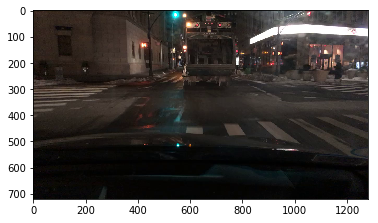

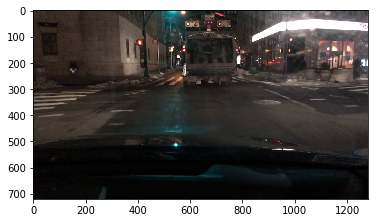

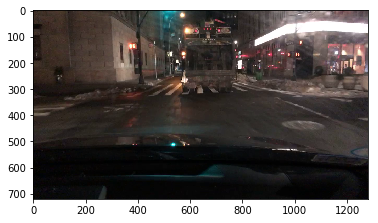

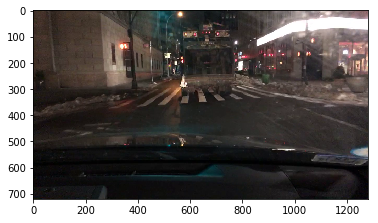

Predicted action: [[0 0 1 0 0]]


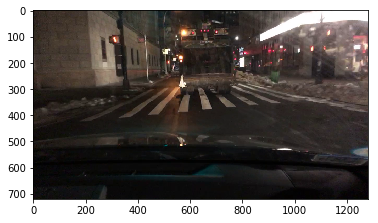

Predicted action: [[0 0 1 0 0]]


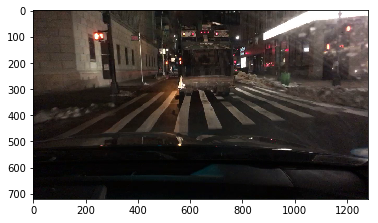

Predicted action: [[0 0 1 0 0]]


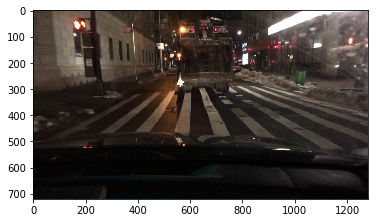

Predicted action: [[0 0 1 0 0]]


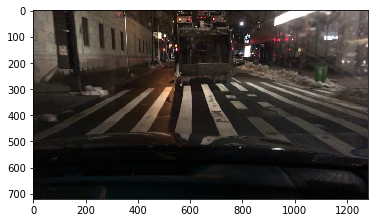

Predicted action: [[0 0 1 0 0]]


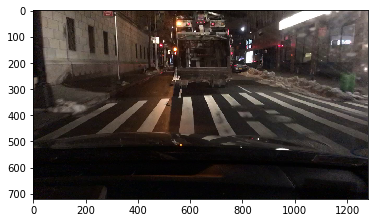

Predicted action: [[0 0 1 0 0]]


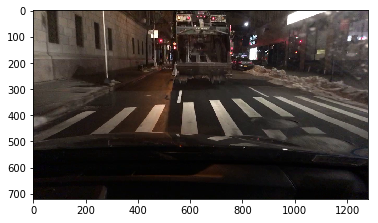

Predicted action: [[0 0 1 0 0]]


In [6]:
# TODO: optimize Ray execution graph to get closer to real-time
example = []
for _ in range(10):
    img = decoder.next.remote()
    img_od = od.detect_objects.remote(img)
    img_seg = seg.segment_image.remote(img)
    
    img_rich = concatenate.remote(2, img, img_seg, img_od)
    
    example.append(img_rich)
    
    plt.imshow(ray.get(img))
    plt.show()
    
    if len(example) == 4:
        img_example = stack.remote(*example)
        action = ray.get(fusion.get_action.remote(img_example))
        print("Predicted action:", action)
        example.pop(0)